# Homework 1

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu





**Students:** Danny Stein, Joseph Padilla

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import sympy

In [3]:
rate_tree = pd.DataFrame({'0':[.0174,np.nan],'0.5':[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='')

time $t$,0,0.5
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [4]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

### 1.4 
What is the price of the swap?

In [32]:
# 1.1 Calculating the tree of bond prices

dt = .5
r0 = .0174
Rates = [.0339,.0095]
Z = np.exp(-r0 * .5)
A = np.exp(r0*.5)
P_1u = 100* np.exp(-rate_tree.iloc[0,1]*dt)
P_1d = 100*np.exp(-rate_tree.iloc[1,1]*dt)
P_df = pd.DataFrame([P_1u,P_1d], columns=['Period_1'])
P_df.insert(0,'Period_0',97.8925)
P_df.iloc[1,0] = 0
P_df['Period_2'] = 100



In [6]:
P_df

,Period_0,Period_1,Period_2
0,97.8925,98.319284,100
1,0.0000,99.526126,100


## 1.2

- The risk neutral probability of an upward movement in interest rates at T = .5 is equal to this: 

$p^* = \frac{A P_{0|2} - P_{1d|2}}{P_{1u|2}-P_{1d|2}}$



In [34]:
bond_matrix = sympy.Matrix([[98.319284,99.526126],[1,1]])
bb = sympy.Matrix([98.7478,1])
bond_matrix.LUsolve(bb)

Matrix([
[0.644927836452502],
[0.355072163547498]])

In [33]:
A*P_df.loc[0,'Period_0']

98.74788025882171

In [35]:
p = (A*P_df.loc[0,'Period_0'] - P_1d)/(P_1u-P_1d)
print(f'The probability of an upward movement in interest rates at time t=0.5 is {np.round(p,5)}')

The probability of an upward movement in interest rates at time t=0.5 is 0.64486


In [36]:
P_float, P_fixed_u,P_fixed_d,Vswap_u, Vswap_d = sympy.symbols("P_float P_fixed_u P_fixed_d V_swap_u V_swap_d")
A = sympy.Matrix([[100,98.3193],[100,99.5261]])
b = sympy.Matrix([50*(.0339-.02),50*(.0095-.02)])
alpha,beta = A.solve(b)

In [40]:
A

Matrix([
[100, 98.3193],
[100, 99.5261]])

In [41]:
position_df = pd.DataFrame(index=['1-period bond','2-period bond'],columns=['price','position','$ holding'],dtype=float)
position_df['price'] = term_struct.iloc[0:2,0].values
position_df["position"] = [alpha,beta]
position_df['$ holding'] = position_df['price']*position_df['position']
position_df.loc['net','$ holding'] = position_df['$ holding'].sum()
position_df.style.format('${:,.4f}')

,price,position,$ holding
1-period bond,$99.1338,$1.0009,$99.2227
2-period bond,$97.8925,$-1.0109,$-98.9632
net,$nan,$nan,$0.2595


- The value of the time-0 swap is $\$0.2595$

# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

In [47]:
payoffs

array([0.  , 1.05])

In [44]:
swap_0 = position_df.iloc[2,2]
rk = .02

payoffs = 100*(rk - np.array(rate_tree.iloc[:,1]))
payoffs[payoffs<0] = 0



In [11]:
swap_tree = pd.DataFrame(np.array(b),columns=['Period_1'] )
swap_tree.insert(0,'Period_0',swap_0)

swap_tree.iloc[1,0] = 0

swap_tree


,Period_0,Period_1
0,0.259491206443485,0.695000000000000
1,0,-0.525000000000000


In [12]:
P_UP = (swap_0-(swap_tree.iloc[1,1]))/(swap_tree.iloc[0,1]-(swap_tree.iloc[1,1]))
P_UP

0.643025579052037

- **Yes**, the probability is exactly the same as the risk-neutral probability of an interest rate increase at time = .5. 

## 2.3 | Pricing The Rate Option




In [13]:
payoffs

array([0.  , 1.05])

In [14]:
A_ = sympy.Matrix([[100,.695],[100,-.525]])
b_ = sympy.Matrix(payoffs)
alpha_, beta_ = A_.solve(b_)
A_.solve(b_)

Matrix([
[0.00598155737704918],
[ -0.860655737704918]])

In [15]:
position = pd.DataFrame(index=['1-period bond','2-period swap'],columns=['price','position','$ holding'],dtype=float)

position.loc['1-period bond','price'] = term_struct.iloc[0,0]
position.loc['2-period swap','price'] = swap_0
position['position'] = [alpha_,beta_]
position['$ holding'] = position['price']*position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()
position.style.format('${:,.4f}')

,price,position,$ holding
1-period bond,$99.1338,$0.0060,$0.5930
2-period swap,$0.2595,$-0.8607,$-0.2233
net,$nan,$nan,$0.3696


- **Yes** the price of the interest rate floor price is the same as we calculated in workbook 1.

**Answer** The price of the interest rate floor is $\$0.3696$.

# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

In [16]:
P_df

,Period_0,Period_1,Period_2
0,97.8925,98.319284,100
1,0.0000,99.526126,100


In [17]:
K = 99
payoffs_call = (P_df['Period_1'].values - K)
payoffs_call[payoffs_call <0] = 0
payoffs_call
A_call = sympy.Matrix([[100,98.319284],[100,99.526126]])
b_call = sympy.Matrix(payoffs_call)
alpha_c, beta_c = A_call.solve(b_call)

In [18]:
position_call = pd.DataFrame(index=['1-period bond','2-period bond'],columns=['price','position','$ holding'],dtype=float)
position_call['price'] = term_struct.iloc[0:2,0].values
position_call["position"] = [alpha_c,beta_c]
position_call['$ holding'] = position_call['price']*position_call['position']
position_call.loc['net','$ holding'] = position_call['$ holding'].sum()
position_call.style.format('${:,.4f}')


,price,position,$ holding
1-period bond,$99.1338,$-0.4286,$-42.4913
2-period bond,$97.8925,$0.4360,$42.6765
net,$nan,$nan,$0.1852


**Answer:** The price of the call is $\$0.1852$.

# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [19]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series(['0','0.5','1'],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0,0.5,1
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)

### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

In [20]:
# 4.1
P_2p = P_df[['Period_1']]
P_2p.insert(0,'Period_0',96.1462)
P_2p.iloc[1,0] = 0
P_2p.loc[0,'Period_2'] = 100*np.exp(-0.05*dt)
P_2p.loc[1,'Period_2'] = 100*np.exp(-.0256*dt)
P_2p.loc[2,'Period_2'] = 100*np.exp(-.0011*dt)
P_2p['Period_3'] = 100
P_2p = P_2p.fillna(0)


In [21]:
P_UP
P_up_sq = np.array((P_UP**2))
P_D = 1-P_UP
P_dd = np.array(P_D**2)
P_u_d = 1-(P_up_sq)
P_d_u = 1-(P_dd)

print(f'The probability of an up movement at t = 1 is equal to {P_up_sq}')



The probability of an up movement at t = 1 is equal to 0.413481895315208


In [22]:
Option_period1 =  P_dd*(0.945015)
Option_period1

0.120423958125579

In [23]:
Option_0 = P_UP*(0) + P_D *Option_period1
Option_0

0.0429882727201404

In [24]:
P_2p['Period_2'] = P_2p['Period_2']-99
P_2p[P_2p <0 ] = 0
P_2p

,Period_0,Period_1,Period_2,Period_3
0,96.1462,98.319284,0.000000,100
1,0.0000,99.526126,0.000000,100
2,0.0000,0.000000,0.945015,100


In [25]:
print(f'The price of the two-period option is ${Option_0}')

The price of the two-period option is $0.0429882727201404


# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

In [48]:
from Binomial_Fixed.binomial import *
from Binomial_Fixed.ratecurves import *

In [49]:
dt = 1/50
TMAT = 1.5

sigma = .3
up = np.exp(sigma*np.sqrt(dt))
down = np.exp(-sigma*np.sqrt(dt))

In [55]:
ratetree = construct_rate_tree(dt, T = TMAT-dt)
ratetree.loc[0,0] = rate_tree.iloc[0,0]
ratetree

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48
state,,,,,,,,,,,,,,,,,,,,,
0,0.0174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
for tsteps in range(ratetree.shape[1]-1):
    ratetree.iloc[:,tsteps +1] = ratetree.iloc[:,tsteps]*up
    ratetree.iloc[tsteps+1,tsteps+1] = ratetree.iloc[tsteps,tsteps] *down

In [61]:
pstars = pd.Series(.65,index = ratetree.columns,name='pstar')
payoff = lambda r: payoff_bond(r,dt)
bondtree = bintree_pricing(payoff=payoff,ratetree = ratetree, pstars = pstars)
bondtree

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48
state,,,,,,,,,,,,,,,,,,,,,
0,95.609681,95.518149,95.425504,95.331779,95.237008,95.141231,95.044493,94.946839,94.848324,94.749002,...,94.332874,94.704769,95.112397,95.558228,96.044920,96.575332,97.152544,97.779879,98.460925,99.199565
1,NaN,95.874749,95.789311,95.702869,95.615456,95.527108,95.437866,95.347773,95.256876,95.165228,...,94.781598,95.124822,95.500895,95.912062,96.360731,96.849491,97.381126,97.958633,98.585242,99.264442
2,NaN,NaN,96.124803,96.045105,95.964505,95.883037,95.800739,95.717649,95.633812,95.549276,...,95.195707,95.512352,95.859192,96.238268,96.651767,97.102034,97.591587,98.123133,98.699584,99.324079
3,NaN,NaN,NaN,96.360630,96.286335,96.211234,96.135363,96.058756,95.981456,95.903505,...,95.577730,95.869752,96.189529,96.538918,96.919903,97.334613,97.785328,98.274494,98.804741,99.378895
4,NaN,NaN,NaN,NaN,96.582979,96.513768,96.443842,96.373234,96.301982,96.230125,...,95.930031,96.199260,96.493999,96.815938,97.166883,97.548763,97.963647,98.413748,98.901442,99.429279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,99.990826,99.992394,99.994089,99.995916,99.997884
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,99.993013,99.994570,99.996249,99.998056
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.995012,99.996554,99.998214


In [71]:
# Pricing the Derivative
STRIKE = 99
EXPIRATION = 1
payoff_deriv = lambda p: np.maximum(STRIKE - p,0)

ratetreeT = ratetree.loc[:,:EXPIRATION]
bondtreeT = bondtree.loc[:,:EXPIRATION]
derivtree = bintree_pricing(payoff=payoff_deriv,ratetree=ratetreeT,undertree=bondtreeT,pstars = pstars, style= 'american')

In [73]:
import seaborn as sns

In [74]:
derivtree

time,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.00
state,,,,,,,,,,,,,,,,,,,,,
0,3.390319,3.481851,3.574496,3.668221,3.762992,3.858769,3.955507,4.053161,4.151676,4.250998,...,7.141100,7.182682,7.217359,7.244584,7.263780,7.274332,7.275591,7.266867,7.247428,7.216500
1,NaN,3.125251,3.210689,3.297131,3.384544,3.472892,3.562134,3.652227,3.743124,3.834772,...,6.504817,6.543269,6.575334,6.600507,6.618250,6.627996,6.629144,6.621056,6.603055,6.574424
2,NaN,NaN,2.875197,2.954895,3.035495,3.116963,3.199261,3.282351,3.366188,3.450724,...,5.916336,5.951876,5.981511,6.004772,6.021165,6.030163,6.031210,6.023717,6.007058,5.980571
3,NaN,NaN,NaN,2.639370,2.713665,2.788766,2.864637,2.941244,3.018544,3.096495,...,5.372365,5.405197,5.432572,5.454057,5.469195,5.477499,5.478455,5.471517,5.456110,5.431620
4,NaN,NaN,NaN,NaN,2.417021,2.486232,2.556158,2.626766,2.698018,2.769875,...,4.869792,4.900107,4.925384,4.945220,4.959193,4.966853,4.967726,4.961307,4.947065,4.924434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='time', ylabel='state'>

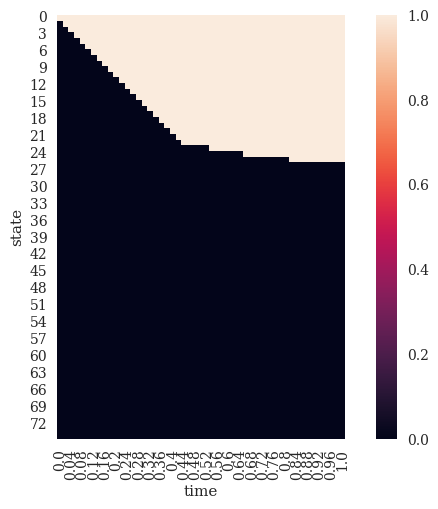

In [75]:
sns.heatmap(exercise_decisions(payoff=payoff_deriv, undertree=bondtreeT, derivtree=derivtree),square=True)